In [1]:
#cells will fill entire width of the browser
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

#always forget to do this for better looking plots
import seaborn
seaborn.set()

In [3]:
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
from statsmodels.tsa import stattools
from sklearn import preprocessing
import random
import copy
import scipy
import sklearn.metrics
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

#energyplus processing functions
from eplusprocessing import *
from buildsys_funcs import *

### Numerical Results

In [16]:
#initialize A, PD
A = np.array([[0.9, 0.0],
              [0.0, -0.4]])

lags = [5,10,20,50]
MC = 100#500
num_samps = 500

num_samps_list = [0,5,10,20,50,100,250,500]

In [5]:
mc_output_by_lag = {}

for M in lags:
    print("Lag round: ", M)
    mc_output_by_lag[M] = np.zeros((MC,3))
    for j in range(MC):
        if j % 10 == 0:
            print("Matrix initialization round: ", j)
        #B = A + randomly sample an element of A to perturb by N(0,1)
        #e = np.unravel_index(np.random.choice([i for i in range(A.shape[0]*A.shape[1])]), dims=A.shape)
        B = copy.copy(A) + np.random.normal(size=A.shape)
        #B[e] += np.random.normal(0,1)
        mc_output_by_lag[M][j,0] = np.linalg.norm(B-A,'fro')
        
        #generate a bunch of samples
        X_s = np.random.normal(size=(2,num_samps))##, size=(2,1000))
        Y_s = A.dot(X_s) + np.asarray([ np.random.normal(0, np.eye(2))[:,0] for i in range(num_samps) ]).T
        Y_s_b = B.dot(X_s) + np.asarray([ np.random.normal(0, np.eye(2))[:,0] for i in range(num_samps) ]).T
        
        f_bin = []
        nf_bin = []
        
        for i in range(X_s.shape[1] - M):
            #for each sample
            nf_sum = [0.0]
            f_sum = [0.0]
            

            for k in range(M):
                #collect likelihood across lag
                nf = likelihood_point(np.expand_dims(X_s[:,i+k], axis=1), np.expand_dims(Y_s[:,i+k], axis=1), A)
                f = likelihood_point(np.expand_dims(X_s[:,i+k], axis=1), np.expand_dims(Y_s_b[:,i+k], axis=1), A)

                nf_sum.append(nf_sum[-1] + nf)
                f_sum.append(f_sum[-1] + f)


            if f_sum[-1] > 0:
                f_bin.append(1)
            else:
                f_bin.append(0)

            if nf_sum[-1] > 0:
                nf_bin.append(1)
            else:
                nf_bin.append(0)
                    
        pred = np.concatenate((f_bin, nf_bin))
        true = np.concatenate((np.ones(np.asarray(f_bin).shape), np.zeros(np.asarray(nf_bin).shape)))

        p = sklearn.metrics.precision_score(true, pred)
        r = sklearn.metrics.recall_score(true, pred)
                
        mc_output_by_lag[M][j,1] = p
        mc_output_by_lag[M][j,2] = r

Lag round:  5
Matrix initialization round:  0
Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initialization round:  40
Matrix initialization round:  50
Matrix initialization round:  60
Matrix initialization round:  70
Matrix initialization round:  80
Matrix initialization round:  90
Lag round:  10
Matrix initialization round:  0
Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initialization round:  40
Matrix initialization round:  50
Matrix initialization round:  60
Matrix initialization round:  70
Matrix initialization round:  80
Matrix initialization round:  90
Lag round:  20
Matrix initialization round:  0
Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initialization round:  40
Matrix initialization round:  50
Matrix initialization round:  60
Matrix initialization round:  70
Matrix initialization round:  80
Ma

In [6]:
for M in lags:
    print(M, ": ", np.mean(mc_output_by_lag[M], axis=0))

5 :  [1.93183533 0.81067325 0.8789697 ]
10 :  [1.87052638 0.85451634 0.91446939]
20 :  [1.75262123 0.91044489 0.92683333]
50 :  [1.90743318 0.97252455 0.9442    ]


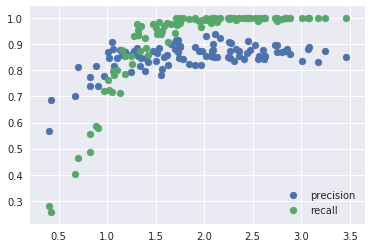

In [12]:
M = 10

plt.scatter(mc_output_by_lag[M][:,0], mc_output_by_lag[M][:,1], label="precision")
plt.scatter(mc_output_by_lag[M][:,0], mc_output_by_lag[M][:,2], label="recall")
plt.legend()
plt.show()

In [8]:
plt.scatter(outputs[:,0],2*((outputs[:,1]*outputs[:,2])/(outputs[:,1] + outputs[:,2])),labe="F1")
plt.legend()
plt.show()

NameError: name 'outputs' is not defined

In [17]:
mc_output_by_lag_true = {}
mc_output_by_lag_est = {}
    
M = 20 #fixed lag

for N in num_samps_list:
    print("Number of training samples: ", N)
    mc_output_by_lag_true[N] = np.zeros((MC,3))
    mc_output_by_lag_est[N] = np.zeros((MC,3))
    for j in range(MC):
        if j % 10 == 0:
            print("Matrix initialization round: ", j)
        B = copy.copy(A) + 0.8*np.random.normal(size=A.shape) #shrink the changes to ensure span of B is closer to A
        
        #generate training set
        X_train = np.random.normal(size=(2,N))
        Y_train = B.dot(X_train) + np.asarray([ np.random.normal(0, np.eye(2))[:,0] for i in range(N) ]).T
        
        #generate validation set
        C = copy.copy(B) + np.random.normal(size=B.shape)
        
        X_val = np.random.normal(size=(2,num_samps))
        Y_val = B.dot(X_val) + np.asarray([ np.random.normal(0, np.eye(2))[:,0] for i in range(num_samps) ]).T
        Y_val_f = C.dot(X_val) + np.asarray([ np.random.normal(0, np.eye(2))[:,0] for i in range(num_samps) ]).T
        
        #retrain A
        #initialize network
        params = {'FEATURE_DIM': A.shape[0], 'OUTPUT_DIM': A.shape[1]}
        net = linear_nnet(params)
        net.l1.weight.data = torch.Tensor(A)  #initialize at A

        #train linear state estimator
        if N == 0:
            B_hat = A
        else:
            train_linear_state_estimation(net, params, X_train, X_val, Y_train, Y_val, epochs=1000, batch_size=int(N/5), verbose=False, validate=False)
            B_hat = net.l1.weight.data.numpy()
        
        mc_output_by_lag_true[N][j,0] = np.linalg.norm(C-B,'fro')
        mc_output_by_lag_est[N][j,0] = np.linalg.norm(C-B_hat, 'fro')
        
        f_bin_true = []
        nf_bin_true = []
        
        f_bin_est = []
        nf_bin_est = []
        
        for i in range(X_val.shape[1] - M):
            #True B
            nf_sum_true = [0.0]
            f_sum_true = [0.0]
            
            #estimated B
            nf_sum_est = [0.0]
            f_sum_est = [0.0]

            for k in range(M):
                #collect likelihood across lag: true B
                nf_true = likelihood_point(np.expand_dims(X_val[:,i+k], axis=1), np.expand_dims(Y_val[:,i+k], axis=1), B)
                f_true = likelihood_point(np.expand_dims(X_val[:,i+k], axis=1), np.expand_dims(Y_val_f[:,i+k], axis=1), B)

                nf_sum_true.append(nf_sum_true[-1] + nf_true)
                f_sum_true.append(f_sum_true[-1] + f_true)
                
                #collect likelihood across lag: estimated B
                nf_est = likelihood_point(np.expand_dims(X_val[:,i+k], axis=1), np.expand_dims(Y_val[:,i+k], axis=1), B_hat)
                f_est = likelihood_point(np.expand_dims(X_val[:,i+k], axis=1), np.expand_dims(Y_val_f[:,i+k], axis=1), B_hat)

                nf_sum_est.append(nf_sum_est[-1] + nf_est)
                f_sum_est.append(f_sum_est[-1] + f_est)

            #evaluate true B likelihoods
            if f_sum_true[-1] > 0:
                f_bin_true.append(1)
            else:
                f_bin_true.append(0)

            if nf_sum_true[-1] > 0:
                nf_bin_true.append(1)
            else:
                nf_bin_true.append(0)
                    
            pred_t = np.concatenate((f_bin_true, nf_bin_true))
            true_t = np.concatenate((np.ones(np.asarray(f_bin_true).shape), np.zeros(np.asarray(nf_bin_true).shape)))

            p_t = sklearn.metrics.precision_score(true_t, pred_t)
            r_t = sklearn.metrics.recall_score(true_t, pred_t)

            mc_output_by_lag_true[N][j,1] = p_t
            mc_output_by_lag_true[N][j,2] = r_t
            
            #evaluate estimated B likelihoods
            if f_sum_est[-1] > 0:
                f_bin_est.append(1)
            else:
                f_bin_est.append(0)

            if nf_sum_est[-1] > 0:
                nf_bin_est.append(1)
            else:
                nf_bin_est.append(0)
                    
            pred_e = np.concatenate((f_bin_est, nf_bin_est))
            true_e = np.concatenate((np.ones(np.asarray(f_bin_est).shape), np.zeros(np.asarray(nf_bin_est).shape)))

            p_e = sklearn.metrics.precision_score(true_e, pred_e)
            r_e = sklearn.metrics.recall_score(true_e, pred_e)

            mc_output_by_lag_est[N][j,1] = p_e
            mc_output_by_lag_est[N][j,2] = r_e


Number of training samples:  5
Matrix initialization round:  0


/home/chase/applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initialization round:  40
Matrix initialization round:  50
Matrix initialization round:  60
Matrix initialization round:  70
Matrix initialization round:  80
Matrix initialization round:  90
Number of training samples:  10
Matrix initialization round:  0
Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initialization round:  40
Matrix initialization round:  50
Matrix initialization round:  60
Matrix initialization round:  70
Matrix initialization round:  80
Matrix initialization round:  90
Number of training samples:  20
Matrix initialization round:  0
Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initialization round:  40
Matrix initialization round:  50
Matrix initialization round:  60
Matrix initialization round:  70
Matrix initialization round:  80
Matrix initial

In [22]:
div_B_true = []
div_B_est = []

prec_B_true = []
prec_B_est = []

rec_B_true = []
rec_B_est = []

for N in num_samps_list:
    print("Number of training samples: ", N)
    print("True B: ", np.mean(mc_output_by_lag_true[N], axis=0))
    print("Est B: ", np.mean(mc_output_by_lag_est[N], axis=0))
    
    div_B_true.append(np.mean(mc_output_by_lag_true[N], axis=0)[0])
    prec_B_true.append(np.mean(mc_output_by_lag_true[N], axis=0)[1])
    rec_B_true.append(np.mean(mc_output_by_lag_true[N], axis=0)[2])
    
    div_B_est.append(np.mean(mc_output_by_lag_est[N], axis=0)[0])
    prec_B_est.append(np.mean(mc_output_by_lag_est[N], axis=0)[1])
    rec_B_est.append(np.mean(mc_output_by_lag_est[N], axis=0)[2])

Number of training samples:  5
True B:  [1.83985735 0.64009141 0.96783673]
Est B:  [2.15603943 0.58993861 0.97944898]
Number of training samples:  10
True B:  [1.96571064 0.65078123 0.97622449]
Est B:  [2.04513369 0.60045816 0.97157143]
Number of training samples:  20
True B:  [1.96839393 0.63406792 0.9705102 ]
Est B:  [2.01248437 0.61533335 0.97922449]
Number of training samples:  50
True B:  [1.91358676 0.62838914 0.97083673]
Est B:  [1.92935034 0.61426096 0.97883673]
Number of training samples:  100
True B:  [1.92402528 0.64941429 0.9735102 ]
Est B:  [1.92989204 0.64438039 0.97126531]


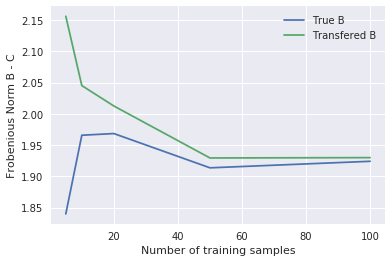

In [25]:
plt.plot(num_samps_list, div_B_true, label="True B")
plt.plot(num_samps_list, div_B_est, label="Transfered B")
plt.legend()
plt.xlabel("Number of training samples")
plt.ylabel("Frobenious Norm B - C")
plt.show()

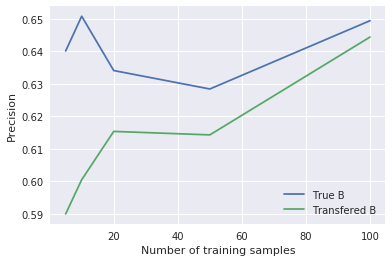

In [30]:
plt.plot(num_samps_list, prec_B_true, label="True B")
plt.plot(num_samps_list, prec_B_est, label="Transfered B")
plt.legend()
plt.xlabel("Number of training samples")
plt.ylabel("Precision")
plt.show()

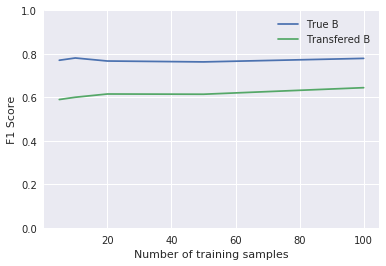

In [28]:
plt.plot(num_samps_list, 2*((np.asarray(prec_B_true)*np.asarray(rec_B_true))/(np.asarray(prec_B_true) + np.asarray(rec_B_true))), label="True B")
plt.plot(num_samps_list, 2*((np.asarray(prec_B_est)*np.asarray(prec_B_est))/(np.asarray(prec_B_est) + np.asarray(prec_B_est))), label="Transfered B")
plt.legend()
plt.xlabel("Number of training samples")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.show()